In [2]:
# Importing modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn import metrics

from gp_qsar import GPytorch_qsar
from gp_qsar.utils import splitter

import pickle

### Initial Model Building

Use to evaluate model building ability of a dataset - in practise we want to use the whole dataset to build the model for use in active learning to ensure we sample from new areas of chemical space.

In [3]:
# Load and Process Data
file = "../data/raw/JNK1_data.csv"
JNK1_df = pd.read_csv(file, sep=";")
JNK1_df = JNK1_df.loc[(JNK1_df["Standard Relation"] == "'='")*(JNK1_df["Standard Units"] == "nM")]
JNK1_df = JNK1_df.drop_duplicates(subset="Smiles").dropna(subset="Standard Value")
JNK1_df.to_csv("../data/processed/JNK1_processed.csv")

smiles = JNK1_df["Smiles"].to_numpy()
activity = -np.log10(JNK1_df["Standard Value"]*1e-9).to_numpy()

train_smiles, test_smiles, train_y, test_y = splitter(smiles, activity, method="scaffold", test_size=0.25)

In [8]:
# build and tune model

model = GPytorch_qsar(list(train_smiles), list(train_y))
model.fit_tune_model(n_trials=100, n_splits=5)

[I 2024-11-04 14:51:33,775] A new study created in memory with name: no-name-e8f5d9a5-1db2-4db0-86d2-7c6abd4339d6
[I 2024-11-04 14:51:36,486] Trial 0 finished with value: 1.7897376537322998 and parameters: {'features': 'FCFP', 'kernel': 'RBF', 'lengthscale': 7.10991852018085, 'noise': 0.002068243584637287, 'n_iter': 195, 'lr': 0.08324593965363418}. Best is trial 0 with value: 1.7897376537322998.
[I 2024-11-04 14:51:37,979] Trial 1 finished with value: 2.264232635498047 and parameters: {'features': 'FCFP,Physchem', 'kernel': 'RBF', 'lengthscale': 2.99223202049866, 'noise': 0.03664252071093624, 'n_iter': 97, 'lr': 0.07851974437968744}. Best is trial 0 with value: 1.7897376537322998.
[I 2024-11-04 14:51:38,910] Trial 2 finished with value: 5.4339879035949705 and parameters: {'features': 'FCFP,Physchem', 'kernel': 'Tanimoto', 'noise': 0.08084165083816496, 'n_iter': 68, 'lr': 0.009776234679498324}. Best is trial 0 with value: 1.7897376537322998.
[I 2024-11-04 14:51:40,405] Trial 3 finished 

Best parameters: {'features': 'ECFP,FCFP', 'kernel': 'Tanimoto', 'noise': 0.029311744274473986, 'n_iter': 200, 'lr': 0.0999790609800195}
Best score: 1.58412504196167


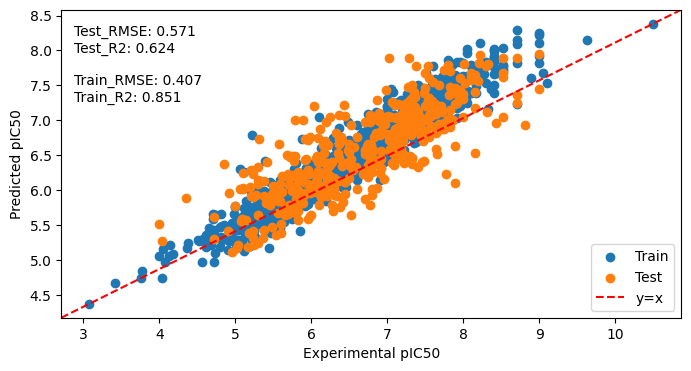

In [20]:

train_pred = model.predict_from_smiles(train_smiles)
test_pred, test_std = model.predict_from_smiles(test_smiles, uncert=True)

fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.scatter(train_y, train_pred, label="Train")
ax.scatter(test_y, test_pred, label="Test")
xlims = ax.get_xlim()
ylims = ax.get_ylim()

ax.plot([xlims[0],xlims[1]], [ylims[0],ylims[1]], linestyle="--", color="red", label = "y=x")
ax.set_xlim(xlims)
ax.set_ylim(ylims)

te_rmse = np.sqrt(metrics.mean_squared_error(test_y, test_pred))
te_r2 = metrics.r2_score(test_y, test_pred)
tr_rmse = np.sqrt(metrics.mean_squared_error(train_y, train_pred))
tr_r2 = metrics.r2_score(train_y, train_pred)

ax.text(0.02, 0.95, f"Test_RMSE: {te_rmse:.3f}\nTest_R2: {te_r2:.3f}\n\nTrain_RMSE: {tr_rmse:.3f}\nTrain_R2: {tr_r2:.3f}", transform=ax.transAxes, verticalalignment="top")
ax.set_ylabel("Predicted pIC50")
ax.set_xlabel("Experimental pIC50")
ax.legend(loc="lower right")

### Rebuild model on whole dataset for use in active learning

In [21]:
model = GPytorch_qsar(smiles, activity)
model.fit_tune_model()

[I 2024-11-04 15:04:24,402] A new study created in memory with name: no-name-7fb73682-2351-4935-b515-b8d6bbc9d41e
[I 2024-11-04 15:04:27,437] Trial 0 finished with value: 1.7775745391845703 and parameters: {'features': 'FCFP', 'kernel': 'RBF', 'lengthscale': 7.10991852018085, 'noise': 0.002068243584637287, 'n_iter': 195, 'lr': 0.08324593965363418}. Best is trial 0 with value: 1.7775745391845703.
[I 2024-11-04 15:04:29,145] Trial 1 finished with value: 2.2644934177398683 and parameters: {'features': 'FCFP,Physchem', 'kernel': 'RBF', 'lengthscale': 2.99223202049866, 'noise': 0.03664252071093624, 'n_iter': 97, 'lr': 0.07851974437968744}. Best is trial 0 with value: 1.7775745391845703.
[I 2024-11-04 15:04:30,206] Trial 2 finished with value: 3.9498682022094727 and parameters: {'features': 'FCFP,Physchem', 'kernel': 'Tanimoto', 'noise': 0.08084165083816496, 'n_iter': 68, 'lr': 0.009776234679498324}. Best is trial 0 with value: 1.7775745391845703.
[I 2024-11-04 15:04:32,269] Trial 3 finished

Best parameters: {'features': 'ECFP,Physchem', 'kernel': 'Tanimoto', 'noise': 0.014326074492304816, 'n_iter': 198, 'lr': 0.09970253875436888}
Best score: 1.536746120452881


In [27]:
# Pickle model for use in REINVENT

with open("../models/JNK1_PIC50.pkl","wb") as f:
    pickle.dump(model, f)